#### Latex Headers
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
$$\newcommand{\adagger}[0]{\hat{a}^{\dagger}}$$
$$\newcommand{\ahat}[0]{\hat{a}}$$
$$\newcommand{\gtwo}[0]{g^{(2)}}$$
$$\newcommand{\H}[0]{\ket{H}}$$
$$\newcommand{\V}[0]{\ket{V}}$$
$$\newcommand{\D}[0]{\ket{D}}$$
$$\newcommand{\AD}[0]{\ket{AD}}$$

# LAB -- QKD (Week 2)

Now that you know how to operate the quED, we want you to take your knowledge of QKD and generate a key via BB84. To do this efficiently, you'll be developing Python scripts to perform taking the data and to do the post-processing. We've provided you with some barebones scripts to get you started. You should verify that they work as expected, and you can make any changes you wish.

## Process for this lab

quTools provides implementation details on how to do BB84 with the quED that can be found on pages 11 - 13 of their [QKD manual](https://www.qutools.com/files/quED/quED-QKD-manual.pdf). In terms of what you'll accomplish in your lab sessions, you'll follow these steps:

1. Verify that Alice is sending an appropriate [number of photons](#Mean-photon-number) to Bob. 
1. Establish a method for Alice to [encode bits](#Encode-bits) and Bob to decode them
1. Based on your setup, construct a [model](#Build-a-model) and estimate the secret key rate (SKR) you expect to see.
1. Generate a raw key, including [taking data](#Take-data) and [sifting the bits](#Bit-sifting)
1. Perform post-processing with provided [Information Reconciliation/Error Correction](#Information-Reconciliation/Error-Correction) and [Privacy Amplification](#Privacy-Amplification) scripts.

## Aims in the lab

As you work on the above process, keep in mind the following topics you'll need to discuss in your write-up:

1. Justify the security of your set-up
1. Explain how you developed your model of SKR
1. Report your experimental SKR and how it compares to the model. Specifically, discuss the error rate you see versus what you expect.
1. Propose steps for improving SKR. Consider how improving the loss of the system would affect the SKR.

## Mean photon number

Last week you spent some time finding $g^{(2)}(0)$ of the SPDC source and looking at the mean number of photons in a pulse. The motivation for doing that was to verify we had an appropriate source for our QKD setup. This is important because...

### BB84's security is based on the no-cloning theorem

The no-cloning theorem states that for a given quanta in a superposition of eigenstates, it's impossible to produce a perfect copy. For more information, see eg [Wootters and Zurek 1982]("https://www.nature.com/articles/299802a0") or [Dieks 1982]("https://www.sciencedirect.com/science/article/pii/0375960182900846?via%3Dihub"). In short, it means that if eavesdropper Eve listens in by: (1) intercepting the photons Alice sends to Bob; (2) measuring them; and (3) then pretending to be Alice by sending identical photons to Bob, she'll create errors in the system that Alice and Bob can detect.

When Alice sends more than one photon to Bob, Eve can perform a photon number splitting attack, which you can read more about in [Brassard, Lutkenhaus, Mor, Sanders 2000]("https://doi.org/10.1103/PhysRevLett.85.1330")

The HBT set-up showed us that using just one output from the SPDC isn't a true single photon source. So, we can approximate that by modeling it as a weak pulse with Poissonian statistics.

Recall that for a Poisson distribution with mean value $\lambda$ the probability of obtaining value k is given by

$$P(k) = e^{-\lambda}\frac{\lambda^k}{k!}$$

We can adjust $\lambda$ by adjusting the laser current and the pulse duration for the pump laser.

In [6]:
# Estimate the probability of getting more than k photons
import scipy
from scipy.stats import poisson



def gt(kk,mu):
    xx = 1-poisson.cdf(k=kk, mu=mu)
    return xx

k = 1 # default is 1: how often does Alice send > 1 photon?
mu = 0.5 # set the mean value (the above text uses lambda instead of mu)
prob = gt(k,mu)

print(f"The probability of getting more than {k} photons with mean {mu} is {prob}")

The probability of getting more than 1 photons with mean 0.5 is 0.09020401043104986


## Encode bits

As you recall from your reading, BB84 uses linear polarization to encode bits. The two bases are $\left[ \H, \V \right]$ (horizontal and vertical) and $\left[ \D, \AD \right]$ (diagonal and anti-diagonal). For the sake of this lab, the default is that photons in the state $\H$ or $\D$ are `0` while photons in $\V$ or $\AD$ are `1`. 

```{note}
**Implementation Note** The default setup with the quED has Bob using a linear polarizer, **not** a polarizing beamsplitter.
```

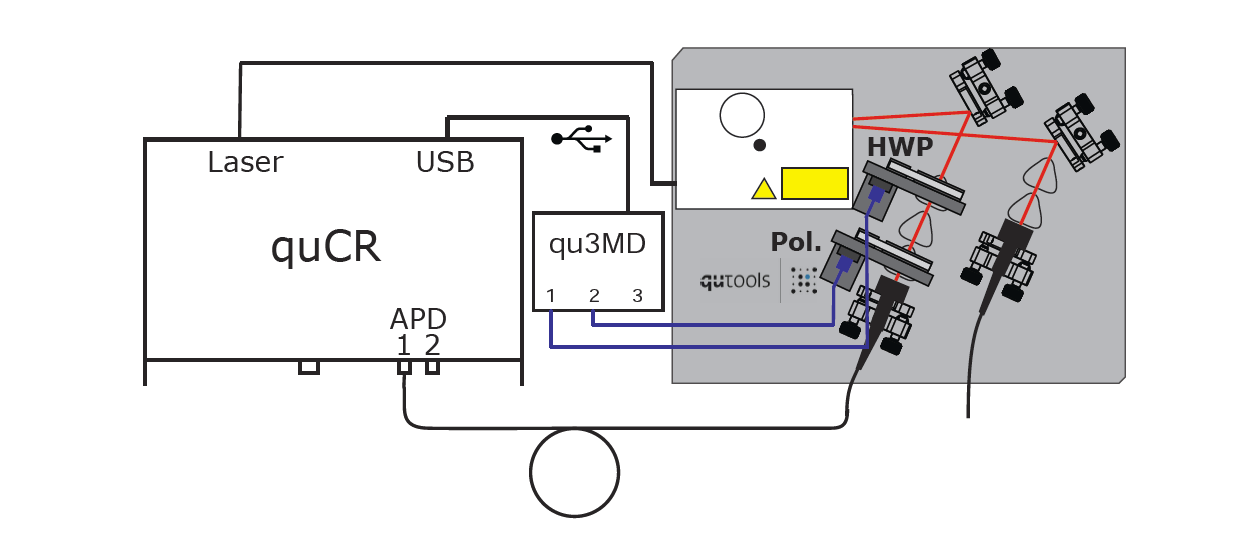

As you can see in the above figure, with the default quED implementation Bob's terminal is simply a polarizer and a detector. That means that for each bit, Bob has to choose a basis and a value to perform his measurement. 

Consider an example with a lossless system. If Alice sends a bit with value `1` in the $\left[ \D, \AD \right]$ basis and Bob decides to measure in the $\left[ \D, \AD \right]$ basis but has his polarizer set to $\D$ (which is `0`) he won't get a click. Even though Alice and Bob are using the same basis, they won't get a bit for their raw key from that photon.

#### Assign random values

The first step is generating the random bits that Alice will send Bob as well as generating the order of which basis Alice will use to transmit each bit and which basis and bit Bob will use to measure it. For the sake of the course, we'll use Python's pseudorandom number generator to make all the choices. 

In [1]:
# Import necessary Libraries

# Generate the basis and bit values for each bit from Alice and Bob

import numpy as np
import random
import matplotlib.pyplot as plt

LENGTH = 10;

# Are we using PBS and 2 detectors? The default is False
PBS  = False

# Assign bit valuess
bH = 0
bV = 1
bD = 0
bA = 1

# Initialize the random bases for Alice and Bob. Let 0 be HV and 1 be AD
basis_Alice = np.zeros((LENGTH))
basis_Bob = np.zeros((LENGTH))

# Now initialize the bit values for Alice
bits_Alice = np.zeros((LENGTH))
bits_Bob = np.zeros((LENGTH)) 

# Now set the correct values for Alice and Bob's rotation
angles_Alice = np.zeros((LENGTH))
angles_Bob = np.zeros((LENGTH))
for x in range (LENGTH):
    basis_Alice[x] = random.randint(0,1)
    basis_Bob[x] = random.randint(0,1)
    bits_Alice[x] = random.randint(0,1)
    bits_Bob[x] = random.randint(0,1)
    angles_Alice[x] = 22.5*basis_Alice[x] - 45*bits_Alice[x]
    if PBS:
        angles_Bob[x] = 22.5*basis_Bob[x] # this will rotate Bob's HWP as needed. You'll measure from 2 detectors
    else:
        angles_Bob[x] = 45*basis_Bob[x] - 90*bits_Bob[x] # this will tells us how to rotate the linear polarizer

# print('Alices Basis :',basis_Alice)
# print('Alices Bits  :',bits_Alice)
# print("Alices Angles: %s" %(angles_Alice))
# print('Bob basis: ', basis_Bob)
# print('Bob bits:  ',bits_Bob)
# print('Bob angles:',angles_Bob)




#### Set correct polarization

Unless you want to rotate the half wave plate (HWP) and polarizer manually for every single bit, you're going to want to make sure you can control polarization optics via a Python script. We've provided a basic script for you below, which you can edit as you see fit.

```{note}
Before you test the script, you need to make sure that your HWP and polarizers are lined up where you think they are, ie if you send $0^{\circ}$ to the HWP, how do you know if it's actually at $0^{\circ}$? For the quED set up, you can set the angle to $0^{\circ}$ through the script or the quTools software and then manually rotate the polarization to get the optics where you want them. Ask one of the instruction staff to show you how to do that if you're unfamiliar with it.
```


## Build a model

Now that you know how to encode bits, it would be helpful to estimate what you expect to see in terms of a secret key rate.

To start with, consider the following questions to determine the raw key:

* How fast can Alice encode photons?
* How often does Alice send Bob a photon? You should take into account both the rep rate of the pump pulses and also how often the pulse sends 0 photons.
* How often will Bob make a measurement of the correct basis and the correct polarization?

After you've done that, consider how many bits you sacrifice for error correction and privacy amplification, which you may want to wait to do once you've taken data and performed the post-processing.

## Take data

Now you have all the pieces you need to take data! The cell immediately below this one is ready for you to define a function and get the data you need to create the raw key.

In [ ]:
import requests
import numpy as np
from urllib.request import urlopen
from requests.models import PreparedRequest
from lxml import html
import re
import time

# User Parameters
integrationTimeValue = 1000 # Integration time in ms, min = 100, max = 10000
pauseTimeValue = 1 # Pause time for motion in s
url = 'http://169.254.69.140:8080/?'

# Accessible parameters
diodeCurrent = "ild"
motor1 = "pm1"
motor2 = "pm2"
integrationTime = "int"
countRate = "cnt"
moterRef = "mref"

def quED_Access(url, action, param, reply = 0, value = []):
    """
    Function that accesses QED via an ethernet connection
    Inputs:
        url - IP adddress of instrument (find in settings)
        action - 'set' or 'get'
        param - the parameter to set or get (see below)
        reply - gives response output text, default false, true to debug
        value - value to pass in, default is empty
    Outputs:
        finalData.response.text - raw string response from instrument
        finalData.name - name of channel measured
        finalData.data - data from measured channel
    """
    
    class finalData:
        pass
    
    # For reading values out
    if (value == []):
        params = {'action':action,'param':param}
        req = PreparedRequest()
        req.prepare_url(url, params)
        response = requests.get(req.url)
    
    # For setting values
    else:
        params = {'action':action,'param':param,'value':value}
        req = PreparedRequest()
        req.prepare_url(url, params)
        response = requests.get(req.url)
    
    if reply == 1:
        if action == 'set':
            print(response.text.split("<body>")[1].split("</body>")[0])
        else:
            print(response.text)
    
    # For case where we measure count data
    if param == 'cnt':
        rawArray = response.text.split('<br>')
        truncArray = rawArray[2:-2] 
        numElem = len(truncArray)
        dataArray = np.zeros(numElem)
        labelArray  = ['0' for i in range(numElem)]

        for elem in range(numElem-1):
            extractLine = truncArray[elem].split(':')
            labelArray[elem] = (extractLine[0])
            dataArray[elem] = int(extractLine[1])

        finalData.name = labelArray
        finalData.data = dataArray
    
    finalData.response = response
    return finalData

output = quED_Access(url, 'set', 'pm1', reply = 1, value = [45])
output = quED_Access(url, 'set', 'pm2', reply = 1, value = [-22.5])
output = quED_Access(url, 'get', 'cnt', reply = 0)
output.data

In [ ]:
def QKD_exp(alice_bases, bob_bases, int_time, det_H_index, det_V_index, num_trials):

    detector_H = []
    detector_V = []
    
    # Change the integration time
    output = quED_Access(url, 'set', 'int', reply = 1, value = [int_time])
    
    for ind in range(len(alice_bases)):
        ## Preparaing both Alice's and Bob's polarization bases
        alice_basis = alice_bases[ind]
        bob_basis = bob_bases[ind]
        # Rotate Alice's HWP
        output = quED_Access(url, 'set', 'pm1', reply = 1, value = [alice_basis])
        # Rotate Bob's HWP
        output = quED_Access(url, 'set', 'pm2', reply = 1, value = [bob_basis])
        temp_H = []
        temp_V = []
        for k in range(num_trials):
            # Grab coincidence counts between detector X and Y
            output = quED_Access(url, 'get', 'cnt', reply = 0)
            counts_H = output.data[det_H_index]
            counts_V = output.data[det_V_index]
            temp_H.append(counts_H)
            temp_V.append(counts_V)

        detector_H.append(np.mean(temp_H))
        detector_V.append(np.mean(temp_V))
    
    return detector_H, detector_V


In [ ]:
## Setup
# some random angles for testing...
alice_bases = np.array([0,22.5,45])
bob_bases = np.array([22.5,0,45])
int_time = 100 # in ms
det_H_index = 0 # detector in the transmission path of the PBS
det_V_index = 1 # detector in the reflection path of the PBS
num_trials = 30

detector_H, detector_V = QKD_exp(alice_bases, bob_bases, int_time, det_H_index, det_V_index, num_trials)
print(detector_H)
print(detector_V)

#### Place holder code
For the purposes of debugging, it can be helpful to have a place holder for the experimental data. The cell below simulates taking BB84 data so that you can test other scripts. The code is entirely commented out so that you won't accidentally run it and develop a conflict with your experimental data. To toggle entire block of code from commented to un-commented, hit `ctrl` + `\`.

In [48]:
# # Place holder for actual data gathering
# TT = 1.0 # set a value for transmission through system, loss, etc.

# detH = []
# detV = []

# for x in range(LENGTH):
#     angle = angles_Alice[x]
#     if random.random() <= TT:
#         if PBS:
#             if angle == 0 or abs(angle) == 45:
#                 if angles_Bob[x] == 0:
#                     detH.append(int(angle == 0))
#                     detV.append(int(angle == 45))
#             else: # Alice is in D or A basis
#                 if angles_Bob[x] == 22.5: # Bob is also in D or A basis
#                     detH.append(int(angle < 0))
#                     detV.append(int(angle > 0))
#             Hval = random.randint(0,1)
#             detH.append(Hval)
#             Vval = 1 - Hval
#             detV.append(1 - Hval)
#         else:
#             if angle*2 == angles_Bob[x]:
#                 detH.append(1)
#             else:
#                 detH.append(0)
#             detV.append(-1)
#     else:
#         detH.append(-1)
#         detV.append(-1) 
# # print(detH)
# # print(detV)
# # print(bits_Alice ==)

## Bit sifting

Now that Alice has finished transmitting and Bob has finished measuring, they need to find cases where Alice sent a photon in the same polarization as Bob measured.

In short, the sifting needs to step through the following questions:
   1. Did Bob get a click?
   1. If yes, did he have the same basis as Alice?
and then discard any bits that don't meet both criteria.

As before, some code is provided below to get you started.

In [49]:
Bob_all = []
Al_all = []


detH = np.array(detH)
detV = np.array(detV)
# find cases where Bob gets exactly 1 click
mask = (detH == 1) ^ (detV == 1) 
# returns array indices where Bob gets exactly 1 click
ix = np.array(np.where(mask))[0] 
# find raw key length
rkl = ix.size 

# look for cases where Alice and Bob have the same basis
if PBS:
    print('Jane needs to write this code')
else:
    for x in range(rkl):
        nn = ix[x]
        AA = angles_Alice[nn]
        AB = angles_Bob[nn]
        if AA*2 == AB:
            Al_all.append(bits_Alice[nn])
            Bob_all.append(bits_Bob[nn])


print(Al_all == Bob_all)
# print(Bob_all)

True


## Information Reconciliation/Error Correction

Alice and Bob want to make sure that any errors in their key are corrected, but they don't want Eve to get too much information. The figure of merit for information reconiciliation/error correction is bit error rate (BER), the ratio of bits that are incorrect.

A basic error correction scheme is provided below. It first estimates the raw BER by having Alice and Bob compare the first `length_reveal` bits over a classical channel. Eve gets all the information Alice and Bob share over the classical channel, so Alice and Bob throw away those bits as they are no longer secret.

**Write-up question:** Where do the errors come from? How is that reflected in your model? Think about the limitations of the polarization optics and dark counts, as a place to start.

Another form of error correction is available [here](https://cascade-python.readthedocs.io/en/latest/protocol.html), although we haven't implemented it in the code.

In [20]:
# Estimate the q BER by revealing some of the bits.

length_reveal = 100

# errors = (bits_tx_sifted[0:length_reveal - 1] != bits_rx_sifted[0:length_reveal - 1]).astype(int)
# errors_total = errors.sum()
# BER = 1.0/length_reveal * errors.sum()

Al_all = np.random.randint(low = 0, high = 2, size = (length_reveal+30,))

# give Bob some errors for testing
err_vec = np.random.choice(2,length_reveal+30,p=[0.9,0.1])
Bob_all = Al_all ^ err_vec

key_test = Al_all[0:length_reveal]
Bob_test = Bob_all[0:length_reveal]
BERest =  np.mean(key_test != Bob_test)
print(BERest)

# Discard those bits
Al_all = Al_all[length_reveal:]
Bob_all = Bob_all[length_reveal:]





0.09


Now that Alice and Bob have an estimate of the quantum BER, they can evaluate to what degree Eve is interfering in their key distribution and if error correction coding will help them. If the qBER is too high (for this particular scheme, the cutoff is when qBER $\geq 0.14$), the error-correction code will actually make the BER worse. This scheme can correct 1 error in every block of 7 bits.

The below section uses a very simple one way Hamming code following the example in the section "Error Correction for Quantum Key Distribution" in Loepp and Wootters [book available online with MIT Library sign in](https://www.cambridge.org/core/books/abs/protecting-information/quantum-cryptography-revisited/8A88AA6C8C88E8A07E535FACEDE3C310). This allows Alice and Bob to reveal a minimum amount of information to Eve while doing error correction; the privacy amplification step then removes the information they did reveal to Eve.

The Hamming code works in the following way: Bob and Alice take their raw key (`a` for Alice and `b` for Bob) and break it into blocks of 7 bits. Each block is multiplied by a 3x7 Hamming matrix `H`. For Alice, this results in `Ha` and for Bob `Hb`. Then Alice sends `Ha` to Bob. Bob finds `Ha - Hb = He` where `e` is the error vector, ie the vector that indicates whether `a == b` for each element. From there, Bob finds `e` and can use that to locate and then correct his bits. For a more in-depth explanation, I highly recommend checking out the linked section.

In [2]:
# Working out the Hamming Error matrix once

n = 7
k = np.log2(n+1).astype(int)

H = np.array([[1,1,1,0,1,0,0],
              [1,1,0,1,0,1,0],
              [0,1,1,1,0,0,1]])

# Define the error correction functions we'll need

def errCor(err_mat,H,a,b,n):
    # Multiply Alice's bits a by H
    at = np.matrix.transpose(a)
    Hat = np.matmul(H,at)
    Hat = np.remainder(Hat,2) # we're doing bitwise operation, so we need to eliminate the overflow

    # Multiply Bob's bits b by H
    bt = np.matrix.transpose(b)
    Hbt = np.matmul(H,bt)
    Hbt = np.remainder(Hbt,2)
    
    # Find Hb - Ha = s 
    s = Hat ^ Hbt
    sT = np.matrix.transpose(s)
    
    # s = He where e is the error vector.
    # If we know s, we can find which row of the error matrix it matches
    # Based on that, we know where the error is
    x = np.where((err_mat==sT).all(axis=1))[0][0].astype(int)
    err_vec = np.zeros((1,n))

    if x < n: 
     err_vec[0,x] = 1
     
    ev = err_vec.astype(int)
    ev = np.reshape(ev,(1,n))

    
    # Bob now has a corrected vector
    # bc = binSub(b,err_vec)
    bc = b ^ ev
    return bc

def makeErrMat(n,k,H):
    err_mat = np.zeros((n+1,k))

    for ii in range(n):
        err_vec = np.zeros((n,1))
        err_vec[ii] = 1
        HeT = np.matmul(H,err_vec)
        HeTT = np.matrix.transpose(HeT)
        # print('err loc',err_vec)
        # print('HeT', HeT)
        err_mat[ii] = HeTT    

    err_mat = err_mat.astype(int)
    return err_mat

err_mat = makeErrMat(n,k,H)

In [16]:
# do error correction for each block

# The following is an example script
LL = 31

Al_all = np.random.randint(low = 0, high = 2, size = (LL,))



err_all = np.zeros((LL)).astype(int)
err_all[3] = 1
err_all[26] = 1
err_all[18] = 1


Bob_all = Al_all ^ err_all


# We've skipped sifting for now
sk = Bob_all.size

cutoff =  sk % n # find key length modulo n

# elimate the "cut-off" bits
Bob = Bob_all[0:-cutoff]

# reshape Alice and Bob's bits into a 2d matrix
a = np.array([[1,0,0,0,1,1,1]])
b = np.array([[1,0,0,0,1,1,0]])


Bob = np.reshape(Bob,(-1,n))
Al  = np.reshape(Al_all[0:-cutoff],(-1,n))
Al[1,:] = a
Bob[1,:] = b

shape = np.shape(Al)
Bob_corr = np.zeros((shape)).astype(int) #initialize matrix for Bob's error correction
words = shape[0]

for ii in range(words):
    Al_word = Al[ii,:]
    Bob_word = Bob[ii,:]
    Bob_word_corr = errCor(err_mat, H, Al_word,Bob_word,n)
    Bob_corr[ii,:] = Bob_word_corr
    
error = np.mean(Al != Bob_corr)
print(error)


0.0


## Privacy Amplification

In this set-up, Eve isn't interacting with the optical set-up, so the only information she has is what Alice and Bob share via the classical channel. 
So, following pg 184 from the above book, we simply get rid of the last 3 bits of each of the 7-word chunks, and Eve will have no information about Alice and Bob's shared key.

There are a variety of ways to perform error correction and privacy amplification. The privacy amplification needs to take into account how the error correction is done: if Alice and Bob reveal more information (which would allow the error correction to work for a worse qBER) they need to eliminate more bits to thwart Eve.

In [ ]:
# Take the giant matrix of error-correct keys, and just skip the last few columns (or rows)
Bob_corr = Bob_corr[:,0:4]
Al = Al[:,0:4]

# Then reshape the key into one long string of bits
Bob_key = np.reshape(Bob_corr,(1,-1))
Al_key = np.reshape(Al,(1,-1))

## Conclusion
In your write-up, think about one way you could improved the SKR using commerically available components. How practical is the component for the speed-up? 